# 1. 데이터 읽기

공공데이터포털에서 제공하는 openAPI를 사용하여 2019.08~2021.08까지의 실황정보를 바탕으로 기온, 눈, 비, 날씨 정보를 조회한다.

## 1.1 알아야할 정보

### 초단기실황 
> 실황정보를 조회하기 위해 **발표일자, 발표시각, 예보지점 X 좌표, 예보지점 Y 좌표의 조회 조건**으로 자료구분코드, 실황값, 발표일자, 발표시각, 예보지점 X 좌표, 예보지점 Y 좌표의 정보를 조회하는 기능<br/>


* 예보지점 X 좌표, 예보지점 Y 좌표는 가이드와 함께 제공하고 있는 **'기상청41_단기예보 조회서비스_오픈API활용가이드_격자_위경도(20210401)'** 에서 알 수 있다. 따라서 이 데이터도 불러와야한다.



### 요청 메시지 명세
항목구분 : 필수(1), 옵션(0), 1건 이상 복수건(1..n), 0건 또는 복수건(0..n), 코드표별첨

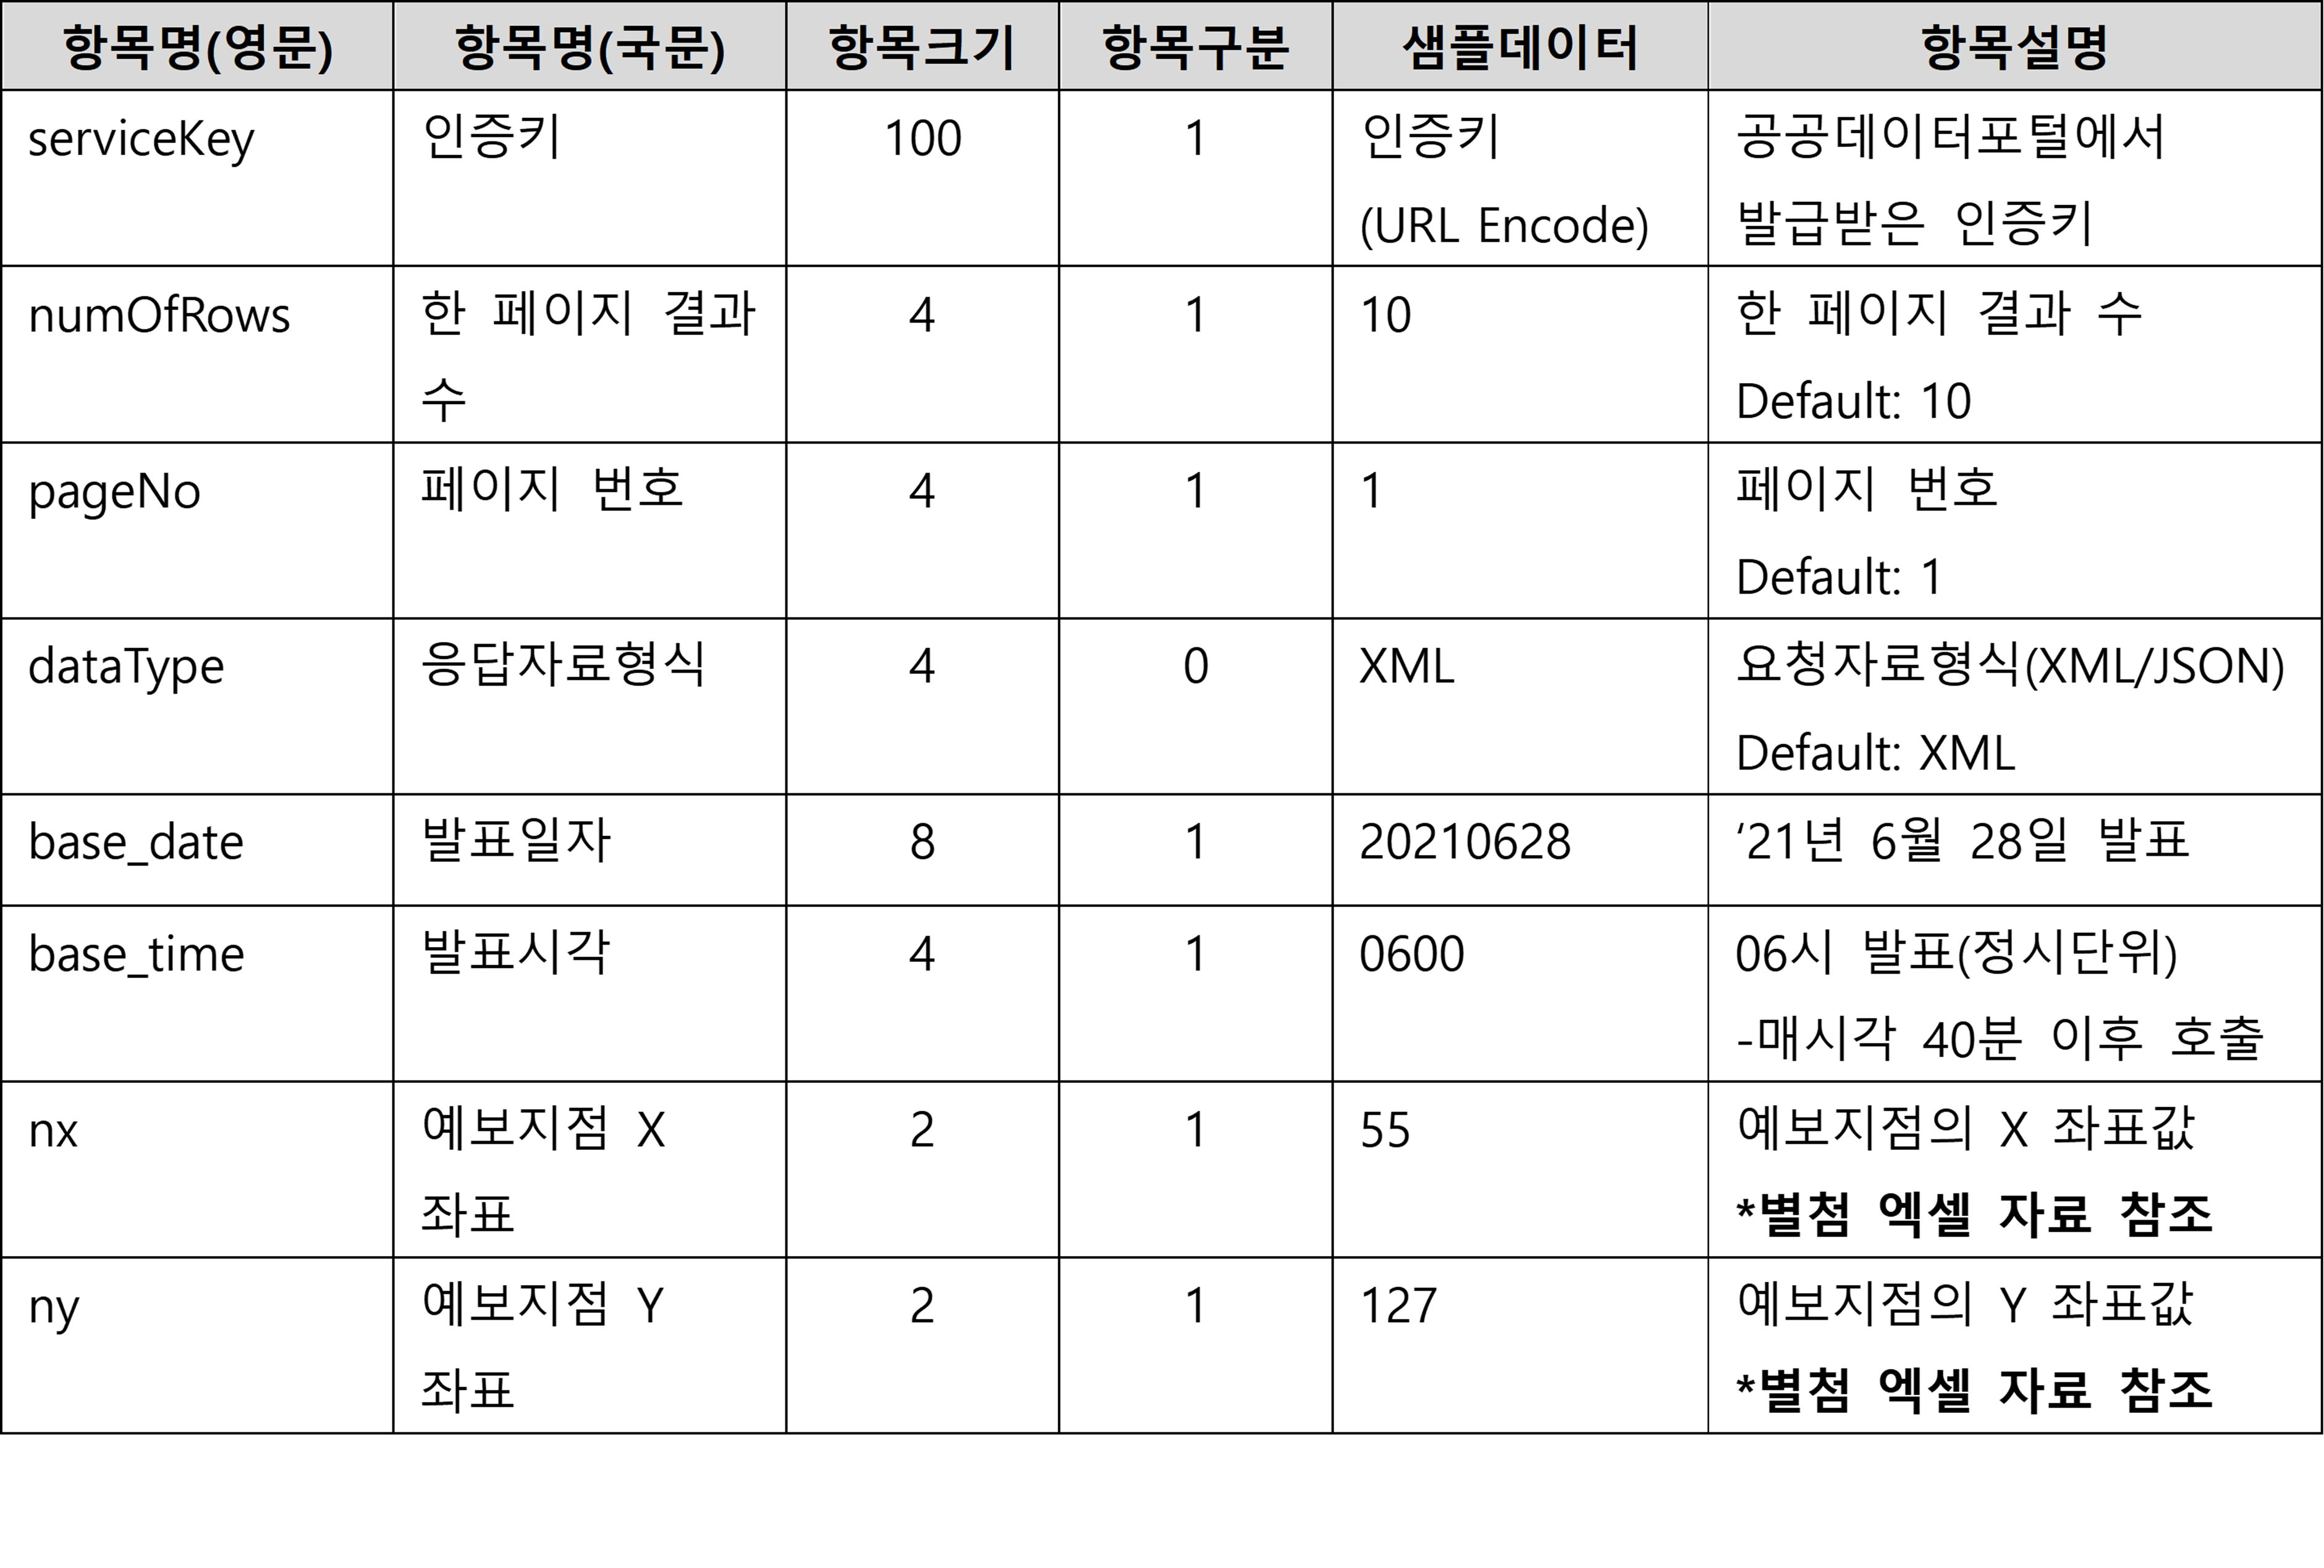


### 응답 메시지 명세
항목구분 : 필수(1), 옵션(0), 1건 이상 복수건(1..n), 0건 또는 복수건(0..n), 코드표별첨

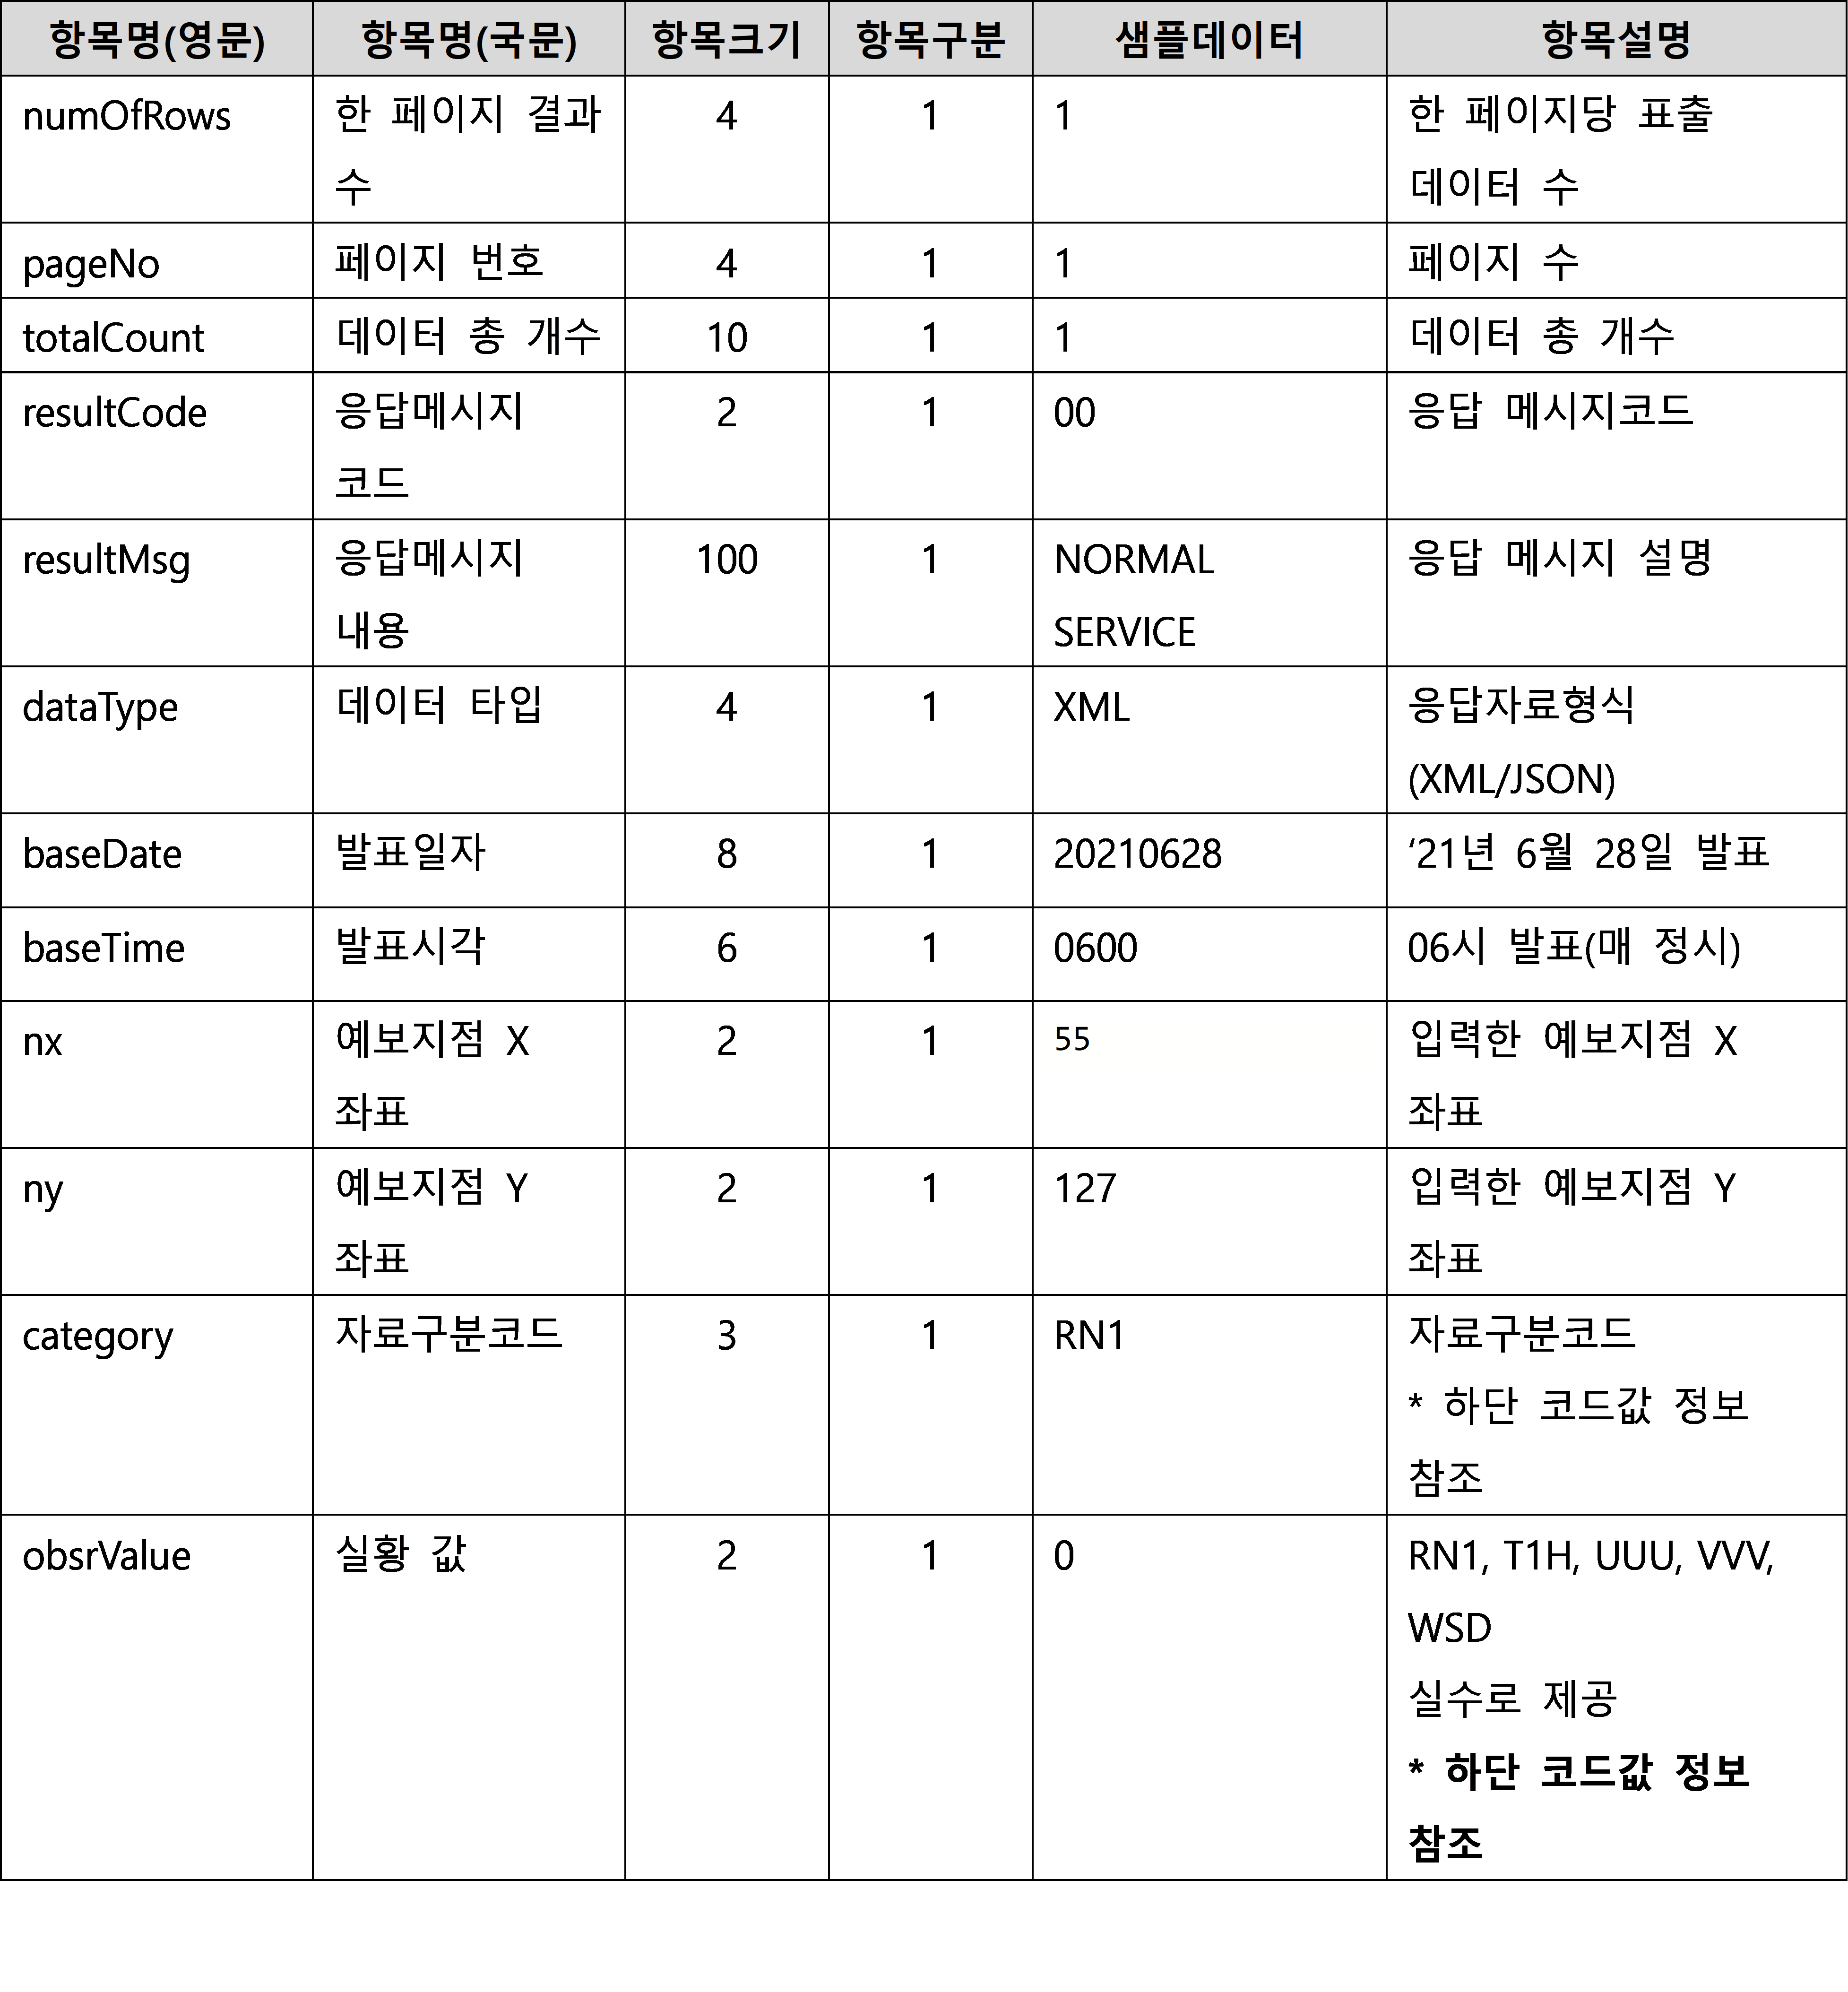

## 1.2 데이터 불러오기

In [2]:
from urllib.parse import urlencode, quote_plus
import requests
import pandas as pd
import numpy as np
import bs4
from bs4 import BeautifulSoup

In [3]:
weather = pd.read_excel('/content/drive/MyDrive/기상청41_단기예보 조회서비스_오픈API활용가이드_격자_위경도(20210401).xlsx', engine='openpyxl')
weather

,구분,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100),위치업데이트,Unnamed: 16
0,kor,1100000000,서울특별시,NaN,NaN,60,127,126,58,48.03,37,33,48.85,126.980008,37.563569,NaN,NaN
1,kor,1111000000,서울특별시,종로구,NaN,60,127,126,58,53.91,37,34,13.36,126.981642,37.570378,NaN,NaN
2,kor,1111051500,서울특별시,종로구,청운효자동,60,127,126,58,14.35,37,35,2.89,126.970652,37.584137,NaN,NaN
3,kor,1111053000,서울특별시,종로구,사직동,60,127,126,58,15.44,37,34,23.77,126.970956,37.573269,NaN,NaN
4,kor,1111054000,서울특별시,종로구,삼청동,60,127,126,59,2.32,37,34,56.73,126.983978,37.582425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,kor,5013060000,제주특별자치도,서귀포시,대천동,52,32,126,28,46.47,33,14,50.91,126.479575,33.247475,NaN,NaN
3770,kor,5013061000,제주특별자치도,서귀포시,중문동,51,32,126,26,12.40,33,14,53.44,126.436778,33.248178,NaN,NaN
3771,kor,5013062000,제주특별자치도,서귀포시,예래동,50,32,126,23,59.67,33,15,3.69,126.399908,33.251025,NaN,NaN
3772,kor,5019000000,이어도,NaN,NaN,28,8,0,0,0.00,0,0,0.00,0.000000,0.000000,NaN,NaN


In [46]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   구분           3774 non-null   object 
 1   행정구역코드       3774 non-null   int64  
 2   1단계          3774 non-null   object 
 3   2단계          3755 non-null   object 
 4   3단계          3505 non-null   object 
 5   격자 X         3774 non-null   int64  
 6   격자 Y         3774 non-null   int64  
 7   경도(시)        3774 non-null   int64  
 8   경도(분)        3774 non-null   int64  
 9   경도(초)        3774 non-null   float64
 10  위도(시)        3774 non-null   int64  
 11  위도(분)        3774 non-null   int64  
 12  위도(초)        3774 non-null   float64
 13  경도(초/100)    3774 non-null   float64
 14  위도(초/100)    3774 non-null   float64
 15  위치업데이트       397 non-null    float64
 16  Unnamed: 16  0 non-null      float64
dtypes: float64(6), int64(7), object(4)
memory usage: 501.4+ KB


# 2. 데이터 정제

## 2.1 결측치 확인

광역시도 단위의 정보와 시군구 단위의 정보도 추가로 들어있어서 결측값이 측정되었지만 우리가 원하는 곳의 정보는 빠짐없이 들어있다. </br></br>
ps. 배달데이터에서 가공한 결과를 지도위에서 출력하고 싶었는데 행정구역의 위경도값은 어떻게 알아오지? 하고 고민하고 있었던 찰나,,,아주 단비같은 소식😃

In [59]:
weather.isna().sum()

행정구역코드         0
1단계            0
2단계           17
3단계          267
격자 X           0
격자 Y           0
경도(시)          0
경도(분)          0
경도(초)          0
위도(시)          0
위도(분)          0
위도(초)          0
경도(초/100)      0
위도(초/100)      0
dtype: int64

In [61]:
weather[weather['3단계'].isna()]

,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100)
0,1100000000,서울특별시,NaN,NaN,60,127,126,58,48.03,37,33,48.85,126.980008,37.563569
1,1111000000,서울특별시,종로구,NaN,60,127,126,58,53.91,37,34,13.36,126.981642,37.570378
19,1114000000,서울특별시,중구,NaN,60,127,126,59,58.71,37,33,39.61,126.999642,37.561003
35,1117000000,서울특별시,용산구,NaN,60,126,126,58,3.08,37,32,9.94,126.967522,37.536094
52,1120000000,서울특별시,성동구,NaN,61,127,127,2,20.40,37,33,38.20,127.039000,37.560611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,4888000000,경상남도,거창군,NaN,77,86,127,54,41.96,35,41,1.05,127.911656,35.683625
3708,4889000000,경상남도,합천군,NaN,81,84,128,10,4.55,35,33,49.02,128.167931,35.563617
3726,5000000000,제주특별자치도,NaN,NaN,52,38,126,30,1.20,33,29,8.50,126.500333,33.485694
3727,5011000000,제주특별자치도,제주시,NaN,53,38,126,31,59.55,33,29,46.72,126.533208,33.496311


In [48]:
#ps. 배달데이터로 지도에서 행정구역을 표시하기 위해서 너무 필요했던 정보!
weather[(weather['1단계']=='서울특별시') & (weather['2단계'].isna())][['행정구역코드',	'1단계','경도(초/100)',	'위도(초/100)']]

,행정구역코드,1단계,경도(초/100),위도(초/100)
0,1100000000,서울특별시,126.980008,37.563569


## 2.2 중복값 확인

In [60]:
weather[weather.duplicated(keep=False)] #중복값 없음

,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100)


## 2.3 불필요한 데이터 제거

In [4]:
#필요없는 열 제거
weather = weather.drop(['구분', '위치업데이트', 'Unnamed: 16'], axis=1)
#이어도 제거
weather = weather[weather['1단계']!='이어도']
weather

,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100)
0,1100000000,서울특별시,NaN,NaN,60,127,126,58,48.03,37,33,48.85,126.980008,37.563569
1,1111000000,서울특별시,종로구,NaN,60,127,126,58,53.91,37,34,13.36,126.981642,37.570378
2,1111051500,서울특별시,종로구,청운효자동,60,127,126,58,14.35,37,35,2.89,126.970652,37.584137
3,1111053000,서울특별시,종로구,사직동,60,127,126,58,15.44,37,34,23.77,126.970956,37.573269
4,1111054000,서울특별시,종로구,삼청동,60,127,126,59,2.32,37,34,56.73,126.983978,37.582425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,5013058000,제주특별자치도,서귀포시,서홍동,53,33,126,33,9.84,33,15,38.28,126.552733,33.260633
3768,5013059000,제주특별자치도,서귀포시,대륜동,52,32,126,30,48.28,33,14,41.22,126.513411,33.244783
3769,5013060000,제주특별자치도,서귀포시,대천동,52,32,126,28,46.47,33,14,50.91,126.479575,33.247475
3770,5013061000,제주특별자치도,서귀포시,중문동,51,32,126,26,12.40,33,14,53.44,126.436778,33.248178


In [57]:
#세종특별시의 경우 날씨데이터는 배달데이터와 다르게 시군구 지역도 세종특별자치시로 채워져있음
weather[weather['1단계']=='세종특별자치시']

,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100)
1239,3600000000,세종특별자치시,NaN,NaN,66,103,0,0,0.00000,0,0,0.00000,127.289069,36.480012
1240,3611000000,세종특별자치시,세종특별자치시,NaN,66,103,0,0,0.00000,0,0,0.00000,127.289069,36.480012
1241,3611025000,세종특별자치시,세종특별자치시,조치원읍,66,106,0,0,0.00000,0,0,0.00000,127.298399,36.604528
1242,3611031000,세종특별자치시,세종특별자치시,연기면,65,105,0,0,0.00000,0,0,0.00000,127.273774,36.541874
1243,3611032000,세종특별자치시,세종특별자치시,연동면,66,105,0,0,0.00000,0,0,0.00000,127.326866,36.559089
1244,3611033000,세종특별자치시,세종특별자치시,부강면,67,104,0,0,0.00000,0,0,0.00000,127.370376,36.527112
1245,3611034000,세종특별자치시,세종특별자치시,금남면,65,103,0,0,0.00000,0,0,0.00000,127.280350,36.463826
1246,3611035000,세종특별자치시,세종특별자치시,장군면,64,104,0,0,0.00000,0,0,0.00000,127.205601,36.496793
1247,3611036000,세종특별자치시,세종특별자치시,연서면,65,106,0,0,0.00000,0,0,0.00000,127.271622,36.592587
1248,3611037000,세종특별자치시,세종특별자치시,전의면,64,108,0,0,0.00000,0,0,0.00000,127.195513,36.681251


In [5]:
#광역시도, 시군구만 있는 데이터 제거
weather = weather[(weather['1단계'].notna()) & (weather['2단계'].notna()) & (weather['3단계'].notna())]
weather

,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100)
2,1111051500,서울특별시,종로구,청운효자동,60,127,126,58,14.35,37,35,2.89,126.970652,37.584137
3,1111053000,서울특별시,종로구,사직동,60,127,126,58,15.44,37,34,23.77,126.970956,37.573269
4,1111054000,서울특별시,종로구,삼청동,60,127,126,59,2.32,37,34,56.73,126.983978,37.582425
5,1111055000,서울특별시,종로구,부암동,60,127,126,57,59.20,37,35,23.48,126.966444,37.589856
6,1111056000,서울특별시,종로구,평창동,60,127,126,58,7.96,37,36,9.08,126.968878,37.602522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,5013058000,제주특별자치도,서귀포시,서홍동,53,33,126,33,9.84,33,15,38.28,126.552733,33.260633
3768,5013059000,제주특별자치도,서귀포시,대륜동,52,32,126,30,48.28,33,14,41.22,126.513411,33.244783
3769,5013060000,제주특별자치도,서귀포시,대천동,52,32,126,28,46.47,33,14,50.91,126.479575,33.247475
3770,5013061000,제주특별자치도,서귀포시,중문동,51,32,126,26,12.40,33,14,53.44,126.436778,33.248178


## 2.4 이상값(outlier) 확인
결측치를 확인하는것만큼 이상한 값이 들어있는지 확인하는 것도 중요한 작업이다. 또한 mean을 수행하려고 한다면 더욱 필수적인데, 유독 이상한 값이 전체의 평균을 좌지우지 할지, 그래서 mean이 데이터의 의미를 표현할 수 있을지 먼저 확인해야한다. 또한 group의 지었을 때 의미를 표현할 수 있을만큼 데이터가 충분한지 등도 살펴보자. mean대신 median을 사용하는 것도 고려하는 것을 잊지 말자.

In [6]:
weather.describe()

,행정구역코드,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100)
count,3.505000e+03,3505.000000,3505.000000,3505.000000,3505.000000,3505.000000,3505.000000,3505.000000,3505.000000,3505.000000,3505.000000
mean,3.727345e+09,70.937518,101.134379,122.515264,28.029672,29.515617,34.594864,28.392582,29.187912,127.591346,36.377962
std,1.194081e+09,15.516960,23.231806,23.681157,19.654093,17.756742,6.765197,16.669068,17.907011,0.875358,1.072408
min,1.111052e+09,21.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,124.714100,33.223572
25%,2.824561e+09,59.000000,80.000000,126.000000,8.000000,14.400000,35.000000,14.000000,13.800000,126.916133,35.388542
50%,4.211065e+09,64.000000,101.000000,127.000000,28.000000,30.080000,36.000000,29.000000,29.350000,127.210653,36.387953
75%,4.623036e+09,85.000000,124.000000,128.000000,46.000000,44.880000,37.000000,41.000000,44.940000,128.393742,37.454300
max,5.013062e+09,144.000000,147.000000,130.000000,59.000000,65.210000,38.000000,59.000000,59.981880,131.864847,38.491644


# 3. Request 요청
초단기실황 요청메시지 예시
```
http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getUltraSrtNcst
?serviceKey=인증키&numOfRows=10&pageNo=1
&base_date=20210628&base_time=0600&nx=55&ny=127
```
* 필요한 것들
  * serviceKey=인증키
  * numOfRows=10
  * pageNo=1
  * base_date=20210628  **=>(20190801~20210831)**
  * base_time=0600 **=>(0000~2300)**
  * nx=55
  * ny=127

<br/>

* 해야할일 
1. 배달데이터에 있는 지역명 이용해서 nx, ny만들기
2. 배달데이터의 시간대를 불러와 사용할 것 같은데(0,1,2...23) base_time 형식(0000,0100....2300)으로 바꿔주는 함수 만들거나 찾아보기.
3. base_date도 배달데이터에 있는 날짜(2019-08-01)를 사용하자. base_date형식(20190801)으로 바꿔주는 함수를 만들거나 있는지 찾아보기.


## 3.1 배달데이터 지역의 nx, ny 알기

In [49]:
#배달 데이터 불러오기
!unzip /content/drive/MyDrive/elicer_col_name.zip -d /content/elice_배달데이터

df_2019=pd.read_csv("/content/elice_배달데이터/elicer_2019_col_name.csv", parse_dates=['날짜'])
df_2020_1=pd.read_csv("/content/elice_배달데이터/elicer_2020_1_col_name.csv", parse_dates=['날짜'])
df_2020_2=pd.read_csv("/content/elice_배달데이터/elicer_2020_2_col_name.csv", parse_dates=['날짜'])
df_2021=pd.read_csv("/content/elice_배달데이터/elicer_2021_col_name.csv", parse_dates=['날짜'])

df = pd.concat([df_2019, df_2020_1, df_2020_2, df_2021], ignore_index=True)
df

Archive:  /content/drive/MyDrive/elicer_col_name.zip
replace /content/elice_배달데이터/elicer_2019_col_name.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/elice_배달데이터/elicer_2019_col_name.csv  
  inflating: /content/elice_배달데이터/elicer_2020_1_col_name.csv  
  inflating: /content/elice_배달데이터/elicer_2020_2_col_name.csv  
  inflating: /content/elice_배달데이터/elicer_2021_col_name.csv  


,날짜,시간대,광역시도,시군구,읍면동,배달건수
0,2019-08-01,0,강원도,속초시,교동,1
1,2019-08-01,0,경기도,고양시 일산동구,마두동,4
2,2019-08-01,0,경기도,고양시 일산동구,백석동,28
3,2019-08-01,0,경기도,고양시 일산동구,식사동,3
4,2019-08-01,0,경기도,고양시 일산동구,장항동,4
...,...,...,...,...,...,...
2382976,2021-08-31,23,충청남도,천안시 서북구,쌍용동,6
2382977,2021-08-31,23,충청북도,제천시,신백동,6
2382978,2021-08-31,23,충청북도,제천시,신월동,2
2382979,2021-08-31,23,충청북도,제천시,천남동,1


날씨데이터의 1단계와 배달데이터의 광역시도는 모두 동일한 값.

In [50]:
print(weather['1단계'].nunique())
weather['1단계'].unique()

17


array(['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
       '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도',
       '경상남도', '제주특별자치도'], dtype=object)

In [54]:
print(df['광역시도'].nunique())
df['광역시도'].unique()

17


array(['강원도', '경기도', '경상남도', '대전광역시', '서울특별시', '전라남도', '전라북도', '제주특별자치도',
       '충청남도', '충청북도', '경상북도', '대구광역시', '부산광역시', '광주광역시', '인천광역시',
       '울산광역시', '세종특별자치시'], dtype=object)

날씨데이터의 지역명의 범위가 훨씬 넓다. 배달데이터의 지역명이 모두 날씨데이터에 포함되어있는지 확인해 보자.

In [63]:
print(weather['2단계'].nunique())
print(weather['2단계'].unique())
print("\n----------------------")
print(df['시군구'].nunique())
df['시군구'].unique()

229
['종로구' '중구' '용산구' '성동구' '광진구' '동대문구' '중랑구' '성북구' '강북구' '도봉구' '노원구' '은평구'
 '서대문구' '마포구' '양천구' '강서구' '구로구' '금천구' '영등포구' '동작구' '관악구' '서초구' '강남구' '송파구'
 '강동구' '서구' '동구' '영도구' '부산진구' '동래구' '남구' '북구' '해운대구' '사하구' '금정구' '연제구'
 '수영구' '사상구' '기장군' '수성구' '달서구' '달성군' '미추홀구' '연수구' '남동구' '부평구' '계양구' '강화군'
 '옹진군' '광산구' '유성구' '대덕구' '울주군' '세종특별자치시' '수원시장안구' '수원시권선구' '수원시 권선구'
 '수원시팔달구' '수원시영통구' '성남시수정구' '성남시중원구' '성남시분당구' '의정부시' '안양시만안구' '안양시동안구'
 '부천시' '광명시' '평택시' '동두천시' '안산시상록구' '안산시단원구' '고양시덕양구' '고양시일산동구' '고양시일산서구'
 '과천시' '구리시' '남양주시' '오산시' '시흥시' '군포시' '의왕시' '하남시' '용인시처인구' '용인시기흥구'
 '용인시수지구' '파주시' '이천시' '안성시' '김포시' '화성시' '광주시' '양주시' '포천시' '여주시' '연천군'
 '가평군' '양평군' '춘천시' '원주시' '강릉시' '동해시' '태백시' '속초시' '삼척시' '홍천군' '횡성군' '영월군'
 '평창군' '정선군' '철원군' '화천군' '양구군' '인제군' '고성군' '양양군' '청주시상당구' '청주시서원구'
 '청주시흥덕구' '청주시청원구' '충주시' '제천시' '보은군' '옥천군' '영동군' '증평군' '진천군' '괴산군' '음성군'
 '단양군' '천안시동남구' '천안시서북구' '공주시' '보령시' '아산시' '서산시' '논산시' '계룡시' '당진시' '금산군'
 '부여군' '서천군' '청양군' '홍성군' '예산군' '태안군' '전주시완산구' '전주시덕진구' '군산시' '익산시'

array(['속초시', '고양시 일산동구', '고양시 일산서구', '광명시', '시흥시', '의정부시', '포천시', '김해시',
       '진주시', '동구', '구로구', '금천구', '마포구', '양천구', '영등포구', '은평구', '순천시',
       '전주시 완산구', '서귀포시', '서산시', '제천시', '안동시', '김포시', '남양주시', '안산시 상록구',
       '창원시 마산회원구', '서구', '강서구', '도봉구', '성북구', '부천시', '양주시', '용인시 처인구',
       '파주시', '화성시', '창원시 마산합포구', '함양군', '달서구', '달성군', '사하구', '강북구',
       '보령시', '원주시', '연천군', '평택시', '창녕군', '해운대구', '노원구', '동작구', '부평구',
       '수원시 권선구', '천안시 동남구', '청주시 청원구', '북구', '나주시', '사천시', '여수시', '서대문구',
       '제주시', '남동구', '군산시', '삼척시', '구미시', '강릉시', '관악구', '수영구', '수성구',
       '수원시 장안구', '홍성군', '포항시 북구', '고양시 덕양구', '양평군', '경주시', '성남시 수정구',
       '여주시', '\\N', '익산시', '울주군', '천안시 서북구', '동두천시', '광양시', '충주시', '송파구',
       '안양시 만안구', '창원시 의창구', '강남구', '영주시', '중구', '칠곡군', '용인시 수지구', '유성구',
       '영천시', '경산시', '서초구', '양산시', '기장군', '구리시', '창원시 성산구', '연수구', '연제구',
       '용산구', '용인시 기흥구', '대덕구', '동래구', '청주시 흥덕구', '안양시 동안구', '동대문구',
       '광주시', '거제시', '수원시 팔달구', '강동구', '음성군', '문경시', '김천시', '오산

In [74]:
level2 = list(weather['2단계'].unique())
SiGunGu = list(df['시군구'].unique())

yes =[]
no=[]

for region in SiGunGu:
  #배달데이터는 시군구 데이터에 띄어쓰기가 되어있는 것이 있는데 비교를 위해 공백을 제거해 날씨데이터와 동일한 모양으로 만든다.
  #왜인지는 모르겠으나,,,창원시는 예외이다. 창원시는 띄어쓰기가 되어있다.
  if not region.startswith('창원') :
    region = region.replace(" ","") 
  
  if region in level2:
    yes.append(region)
  else:
    no.append(region)

print(no) #모두 존재! (\\N은 세종특별자치시이다. 배달데이터는 세종특별자치시에 값이 들어있지 않다.)

['\\N']


In [76]:
print(len(yes))
print(yes)

140
['속초시', '고양시일산동구', '고양시일산서구', '광명시', '시흥시', '의정부시', '포천시', '김해시', '진주시', '동구', '구로구', '금천구', '마포구', '양천구', '영등포구', '은평구', '순천시', '전주시완산구', '서귀포시', '서산시', '제천시', '안동시', '김포시', '남양주시', '안산시상록구', '창원시 마산회원구', '서구', '강서구', '도봉구', '성북구', '부천시', '양주시', '용인시처인구', '파주시', '화성시', '창원시 마산합포구', '함양군', '달서구', '달성군', '사하구', '강북구', '보령시', '원주시', '연천군', '평택시', '창녕군', '해운대구', '노원구', '동작구', '부평구', '수원시권선구', '천안시동남구', '청주시청원구', '북구', '나주시', '사천시', '여수시', '서대문구', '제주시', '남동구', '군산시', '삼척시', '구미시', '강릉시', '관악구', '수영구', '수성구', '수원시장안구', '홍성군', '포항시북구', '고양시덕양구', '양평군', '경주시', '성남시수정구', '여주시', '익산시', '울주군', '천안시서북구', '동두천시', '광양시', '충주시', '송파구', '안양시만안구', '창원시 의창구', '강남구', '영주시', '중구', '칠곡군', '용인시수지구', '유성구', '영천시', '경산시', '서초구', '양산시', '기장군', '구리시', '창원시 성산구', '연수구', '연제구', '용산구', '용인시기흥구', '대덕구', '동래구', '청주시흥덕구', '안양시동안구', '동대문구', '광주시', '거제시', '수원시팔달구', '강동구', '음성군', '문경시', '김천시', '오산시', '성남시중원구', '단양군', '하남시', '중랑구', '김제시', '미추홀구', '괴산군', '이천시', '아산시', '논산시', '남구', '안산시단원구', '성남시분당구', '철원군', '예천군', '

In [78]:
print(weather['3단계'].nunique())
print(weather['3단계'].unique())
print("\n----------------------")
print(df['읍면동'].nunique())
df['읍면동'].unique()

3165
['청운효자동' '사직동' '삼청동' ... '대천동' '중문동' '예래동']

----------------------
826


array(['교동', '마두동', '백석동', '식사동', '장항동', '정발산동', '일산동', '탄현동', '광명동',
       '철산동', '하안동', '조남동', '가능동', '금오동', '민락동', '신곡동', '용현동', '의정부동',
       '호원동', '소흘읍', '삼방동', '삼정동', '계동', '본성동', '봉곡동', '신안동', '평거동',
       '성남동', '개봉동', '고척동', '구로동', '오류동', '독산동', '망원동', '목동', '대림동',
       '도림동', '신길동', '영등포동', '갈현동', '조례동', '해룡면', '효자동2가', '효자동3가', '동홍동',
       '서귀동', '서홍동', '동문동', '석림동', '명동', '의림동', '장락동', '소하동', '동성동',
       '이현동', '중안동', '신백동', '영천동', '녹양동', '구산동', '어방동', '외동', '인사동',
       '태화동', '풍무동', '다산동', '본오동', '봉황동', '삼계동', '주촌면', '상봉동', '장대동',
       '칠암동', '양덕동', '합성동', '정하동', '비산동', '염창동', '화곡동', '궁동', '방학동',
       '정릉동', '대조동', '청전동', '금호동', '중산동', '풍동', '덕이동', '주엽동', '일직동',
       '감정동', '별내동', '오남읍', '괴안동', '옥길동', '목감동', '백석읍', '남사면', '장암동',
       '동패동', '신읍동', '산척동', '내동', '대성동', '부원동', '대안동', '상대동', '옥봉동',
       '산호동', '상남동', '오동동', '함양읍', '금곡동', '삼산동', '옥동', '옥야동', '천리동',
       '감삼동', '용산동', '이곡동', '다사읍', '명지동', '하단동', '미아동', '공항동', '도봉동',
       '창동', '신정동', '영

In [82]:
weather[weather['3단계'].str.startswith('마두')]

,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100)
1528,4128556000,경기도,고양시일산동구,마두1동,57,129,126,47,30.71,37,39,10.92,126.791864,37.653033
1529,4128557000,경기도,고양시일산동구,마두2동,56,128,126,47,11.64,37,39,2.89,126.786567,37.650803


In [83]:
df[df['읍면동']=='마두동']

,날짜,시간대,광역시도,시군구,읍면동,배달건수
1,2019-08-01,0,경기도,고양시 일산동구,마두동,4
192,2019-08-01,11,경기도,고양시 일산동구,마두동,11
312,2019-08-01,12,경기도,고양시 일산동구,마두동,27
440,2019-08-01,13,경기도,고양시 일산동구,마두동,15
559,2019-08-01,14,경기도,고양시 일산동구,마두동,19
...,...,...,...,...,...,...
516546,2020-01-31,16,경기도,고양시 일산동구,마두동,1
516983,2020-01-31,18,경기도,고양시 일산동구,마두동,1
517236,2020-01-31,19,경기도,고양시 일산동구,마두동,1
517495,2020-01-31,20,경기도,고양시 일산동구,마두동,1


In [77]:
level3 = list(weather['3단계'].unique())
Dong = list(df['읍면동'].unique())

yes =[]
no=[]

for region in Dong:
  #배달데이터는 시군구 데이터에 띄어쓰기가 되어있는 것이 있는데 비교를 위해 공백을 제거해 날씨데이터와 동일한 모양으로 만든다.
  #왜인지는 모르겠으나,,,창원시는 예외이다. 창원시는 띄어쓰기가 되어있다.
  if not region.startswith('창원') :
    region = region.replace(" ","") 
  
  if region in level3:
    yes.append(region)
  else:
    no.append(region)

print(no)

['마두동', '장항동', '광명동', '철산동', '하안동', '조남동', '금오동', '신곡동', '용현동', '의정부동', '호원동', '삼방동', '삼정동', '계동', '본성동', '봉곡동', '개봉동', '고척동', '구로동', '독산동', '망원동', '대림동', '조례동', '효자동2가', '효자동3가', '서귀동', '석림동', '의림동', '장락동', '소하동', '중안동', '어방동', '외동', '인사동', '본오동', '봉황동', '삼계동', '장대동', '칠암동', '양덕동', '합성동', '정하동', '화곡동', '궁동', '방학동', '정릉동', '풍동', '덕이동', '주엽동', '일직동', '감정동', '괴안동', '옥길동', '남사면', '동패동', '신읍동', '산척동', '대안동', '옥봉동', '옥야동', '천리동', '이곡동', '명지동', '하단동', '도봉동', '창동', '신정동', '영등포동1가', '연향동', '왕지동', '명천동', '강제동', '모산동', '중앙로1가', '중앙로2가', '태장동', '산현동', '서상동', '소태동', '가양동', '상계동', '쌍문동', '신대방동', '청천동', '하소동', '낙양동', '내당동', '평리동', '신호동', '방화동', '산곡동', '청당동', '반곡동', '오산동', '오치동', '파호동', '등촌동', '마곡동', '온수동', '죽정동', '고암동', '논곡동', '와동동', '내발산동', '신월동', '십정동', '야당동', '벌리동', '수정동', '길음동', '주약동', '신포동1가', '광석동', '정상동', '천왕동', '홍은동', '화봉동', '예천동', '가좌동', '망경동', '다대동', '율세동', '불광동', '천남동', '삼도이동', '목동동', '간석동', '동대동', '장림동', '지곡동', '초전동', '인의동', '나운동', '관설동', '동현동', '아라일동', '회원동', '봉천동', '광안동', '우동', '범박동', 

## 3.2 openAPI 이용해서 요청하기

In [51]:
url = 'http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getUltraSrtNcst'
service_key = 'BiRpoVSutytS0m4hAui5oVw5hElTkGPwCYkftxsOFFzkyWek%2FGAF1FBAbAcbbh2DhIfotaAfMIyIQQfjnB6tWA%3D%3D'

In [ ]:
params ={'serviceKey' : '서비스키', 'pageNo' : '1', 'numOfRows' : '1000', 'dataType' : 'XML', 'base_date' : '20210628', 'base_time' : '0600', 'nx' : '55', 'ny' : '127' }

response = requests.get(url, params=params)
print(response.content)